In [6]:
!pip install -q pandas numpy scipy scikit-learn sentence-transformers tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Optional, Tuple
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon
from tqdm.notebook import tqdm

_sentence_model = None

In [8]:
def load_dataset(path: str | Path, *, text_col: str = "text", label_col: str | None = None):
    df = pd.read_csv(path)
    texts = df[text_col].astype(str).fillna("").tolist()
    labels = df[label_col] if label_col and label_col in df.columns else None
    return texts, labels

In [21]:
def get_token_distributions(texts_a: List[str], texts_b: List[str], *,
                             ngram_range=(1, 2), max_features=10000):
    vec = CountVectorizer(ngram_range=ngram_range, max_features=max_features, lowercase=True)
    vec.fit(texts_a + texts_b)

    Xa = vec.transform(texts_a)
    Xb = vec.transform(texts_b)

    pa = np.asarray(Xa.sum(axis=0)).flatten().astype(float)
    pb = np.asarray(Xb.sum(axis=0)).flatten().astype(float)

    pa /= pa.sum()
    pb /= pb.sum()

    vocab = vec.get_feature_names_out().tolist()
    return pa, pb, vocab

In [10]:
def _load_sentence_model(model_name="sentence-transformers/all-MiniLM-L6-v2"):
    global _sentence_model
    if _sentence_model is None:
        from sentence_transformers import SentenceTransformer
        _sentence_model = SentenceTransformer(model_name)
    return _sentence_model

def _mmd(emb_a, emb_b, gamma=None):
    from sklearn.metrics.pairwise import euclidean_distances
    if gamma is None:
        dists = euclidean_distances(np.vstack([emb_a, emb_b]))
        gamma = 1 / (2 * np.median(dists) ** 2 + 1e-12)
    Kxx = np.exp(-gamma * euclidean_distances(emb_a) ** 2)
    Kyy = np.exp(-gamma * euclidean_distances(emb_b) ** 2)
    Kxy = np.exp(-gamma * euclidean_distances(emb_a, emb_b) ** 2)
    m, n = len(emb_a), len(emb_b)
    return (Kxx.sum() / (m * m) + Kyy.sum() / (n * n) - 2 * Kxy.sum() / (m * n))

def embedding_mmd(texts_a, texts_b, model_name="sentence-transformers/all-MiniLM-L6-v2", sample_size=4000):
    model = _load_sentence_model(model_name)
    a, b = texts_a[:sample_size], texts_b[:sample_size]
    emb_a = model.encode(a, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
    emb_b = model.encode(b, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
    return _mmd(emb_a, emb_b)

In [11]:
def label_kl(labels_a: pd.Series, labels_b: pd.Series) -> float:
    import scipy.stats as st
    pa = labels_a.value_counts(normalize=True).sort_index()
    pb = labels_b.value_counts(normalize=True).reindex(pa.index, fill_value=1e-12)
    return float(st.entropy(pa, pb, base=2))

In [22]:
def quick_report(path_a, path_b, text_col="text", label_col="label",
                 ngram_range=(1, 2), max_features=10000):
    texts_a, labels_a = load_dataset(path_a, text_col=text_col, label_col=label_col)
    texts_b, labels_b = load_dataset(path_b, text_col=text_col, label_col=label_col)

    print(f"📁 Porównanie: {Path(path_a).name} vs {Path(path_b).name}")
    print(f"Dokumenty: {len(texts_a):,} vs {len(texts_b):,}")

    pa, pb, vocab = get_token_distributions(texts_a, texts_b,
                                            ngram_range=ngram_range,
                                            max_features=max_features)

    print(f"🔣 Token JS divergence : {js_divergence(pa, pb):.4f}")
    print(f"📚 Vocab overlap        : {vocab_overlap(vocab, vocab) * 100:.2f}%")
    print(f"📝 Śr. dł. dokumentu     : {avg_doc_len(texts_a):.1f} vs {avg_doc_len(texts_b):.1f} słów")

    if labels_a is not None and labels_b is not None:
        print(f"🏷️ Label KL divergence  : {label_kl(labels_a, labels_b):.4f}")

    try:
        print(f"🤖 Embedding MMD^2      : {embedding_mmd(texts_a, texts_b):.4f}")
    except Exception as e:
        print(f"⚠️ Embedding MMD pominięty: {e}")

In [23]:
quick_report("v1_training.csv", "extreme_examples.csv", text_col="TEXT", label_col="LABEL")

📁 Porównanie: v1_training.csv vs extreme_examples.csv
Dokumenty: 10,041 vs 174
🔣 Token JS divergence : 0.4074
📚 Vocab overlap        : 100.00%
📝 Śr. dł. dokumentu     : 12.4 vs 20.6 słów
🏷️ Label KL divergence  : 1.2442


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

🤖 Embedding MMD^2      : 0.0542


In [28]:
quick_report("BAN-PL.csv", "extreme_examples.csv", text_col="TEXT", label_col="LABEL")

📁 Porównanie: BAN-PL.csv vs extreme_examples.csv
Dokumenty: 24,000 vs 174
🔣 Token JS divergence : 0.3613
📚 Vocab overlap        : 100.00%
📝 Śr. dł. dokumentu     : 30.2 vs 20.6 słów
🏷️ Label KL divergence  : 0.1355


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

🤖 Embedding MMD^2      : 0.0646


In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings_tsne_pca(texts_a, texts_b, label_a="Set A", label_b="Set B",
                                  model_name="sentence-transformers/all-MiniLM-L6-v2",
                                  sample_size=1000, random_state=42):
    model = _load_sentence_model(model_name)

    a = texts_a[:sample_size]
    b = texts_b[:sample_size]

    print("⚙️ Calculating embeddings...")
    emb_a = model.encode(a, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
    emb_b = model.encode(b, batch_size=64, show_progress_bar=True, normalize_embeddings=True)

    emb = np.vstack([emb_a, emb_b])
    labels = [label_a] * len(emb_a) + [label_b] * len(emb_b)

    print("⚙️ Performing PCA dimensionality reduction...")
    pca = PCA(n_components=2, random_state=random_state)
    emb_pca = pca.fit_transform(emb)

    print("⚙️ Performing t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=random_state, init='pca', learning_rate='auto')
    emb_tsne = tsne.fit_transform(emb)

    def plot_embedding(embeddings, title):
        plt.figure(figsize=(8,6))
        for label, color in zip([label_a, label_b], ['blue', 'red']):
            idx = [i for i, l in enumerate(labels) if l == label]
            plt.scatter(embeddings[idx, 0], embeddings[idx, 1], c=color, label=label, alpha=0.6, s=15)
        plt.legend()
        plt.title(title)
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.grid(True)
        plt.show()

    plot_embedding(emb_pca, "PCA - Embeddings Visualization")
    plot_embedding(emb_tsne, "t-SNE - Embeddings Visualization")

In [34]:
texts_a, _ = load_dataset("v1_training.csv", text_col="TEXT")
texts_b, _ = load_dataset("extreme_examples.csv", text_col="TEXT")

⚙️ Calculating embeddings...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

⚙️ Performing PCA dimensionality reduction...
⚙️ Performing t-SNE dimensionality reduction...


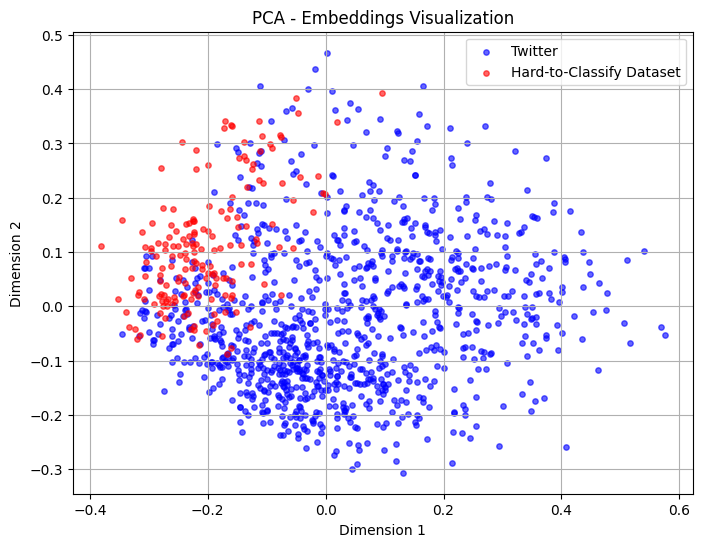

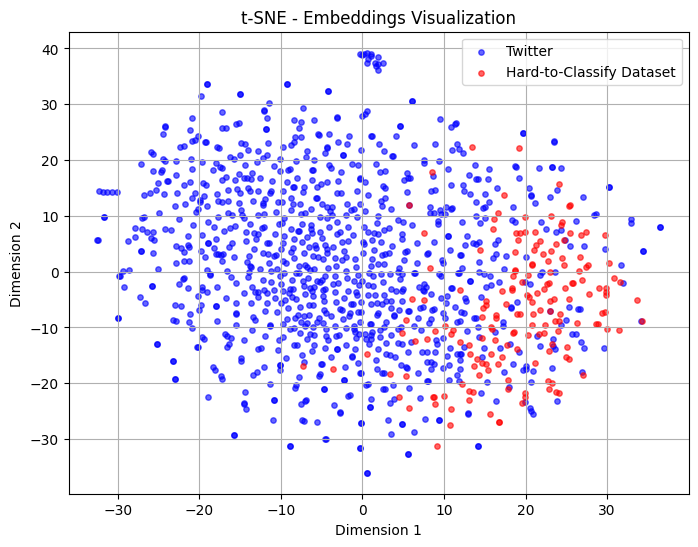

In [35]:
visualize_embeddings_tsne_pca(
    texts_a=texts_a,
    texts_b=texts_b,
    label_a="Twitter",
    label_b="Hard-to-Classify Dataset",
    sample_size=1000
)

In [36]:
texts_a, _ = load_dataset("BAN-PL.csv", text_col="TEXT")
texts_b, _ = load_dataset("extreme_examples.csv", text_col="TEXT")

⚙️ Calculating embeddings...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

⚙️ Performing PCA dimensionality reduction...
⚙️ Performing t-SNE dimensionality reduction...


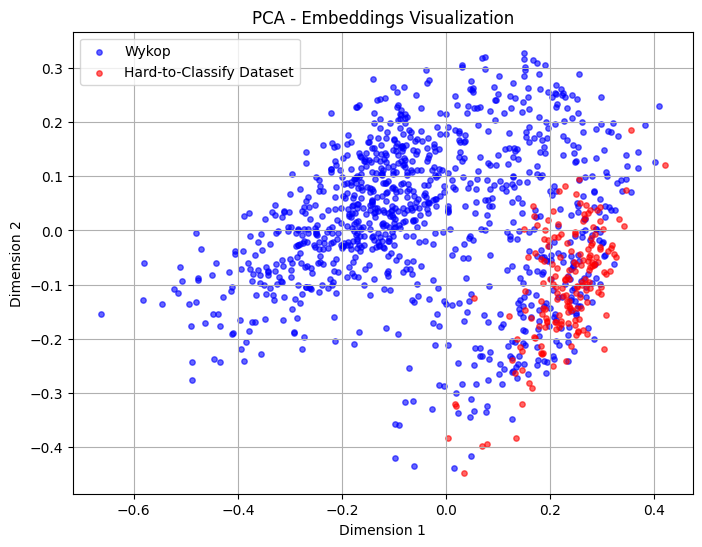

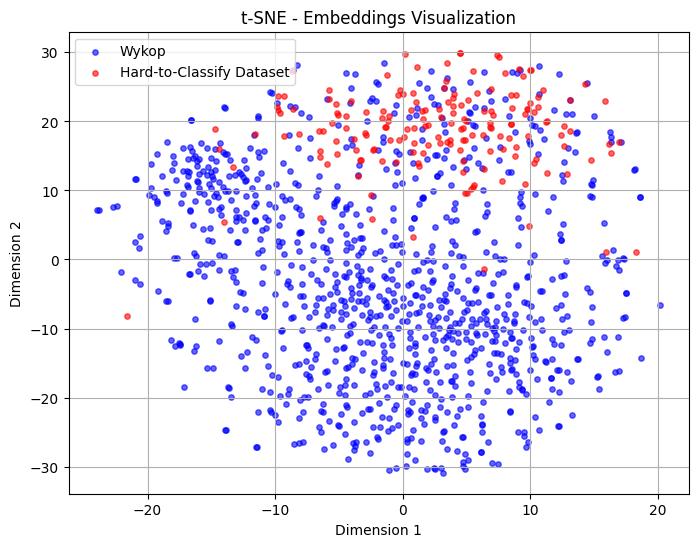

In [37]:
visualize_embeddings_tsne_pca(
    texts_a=texts_a,
    texts_b=texts_b,
    label_a="Wykop",
    label_b="Hard-to-Classify Dataset",
    sample_size=1000
)